# Power Spectrum Estimation

This notebook is to understand the details of the power spectrum, its computation with FFT, carefully considering scaling issues, units and interpretation.

Important lessons to be learned (non-windowed case)

- Normalizing the FFT by sqrt(N)
    - squared magnitudes: __Energy Spectrum [V^2 s]__ - grows w/ N
- Normalizing the FFT by N: 
    - magnitudes are __RMS amplitudes [V]__ (for the given frequency bin)
    - squared magnitudes: __Power Spectrum [V^2]__
    - squared magnitudes normalized by the width of the bin: __Power Spectral Density [V^2/Hz]__
    
__Power spectral density better suits wide-band (i.e. noise) signals. Power spectrum is better for interpreting narrow-band (i.e. single frequency) signals.__

__Alternative view on DFT__: By looking at the definition of DFT, it can be interpreted as a mixer (complex exponential multipler) and a low-pass filer (box-car or simple average). The low-pass filter (hence the DFT bins) will gets narrower as you increase N.

TODO: understand why we need to scale bins /2 (except at DC) - Hint: this is needed only for real (non-complex) signals

Create a discrete sinusoid signal with some added noise. We assume that this is a voltage signal.

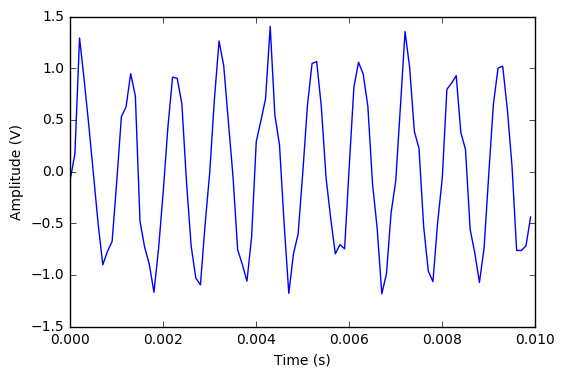

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# constants
FS = 1e4        # sampling rate (Hz)
SIG_F = 1e3     # signal frequency (Hz)
SIG_DB = 0      # signal amplitude (dB)
NOISE_DB = -15  # noise amplitude (dB)
T = 1           # signal length (s)
dT = 1 / FS

t = np.arange(0, T, 1/FS)
sig = np.sin(2 * np.pi * SIG_F * t) * (10 ** (SIG_DB / 20))
noise = np.random.randn(sig.size) * (10 ** (NOISE_DB / 20))
samples = sig + noise

plt.plot(t[:100], samples[:100])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

Calculate the average power of the clean signal and of the noise from the time domain samples. Compute SNR. 

__Note__: the power of a sinusoid with unit amplitude is -3dB.

In [39]:
P_sig_t = np.mean(sig ** 2) # same as np.sum((sig ** 2) * dT) / T
P_noise_t = np.mean(noise ** 2)
SNR_t = 10 * np.log10(P_sig_t / P_noise_t)

print('P(sig)= %.2f V^2, P(noise)= %.2f V^2, SNR= %.2f dB' % (P_sig_t, P_noise_t, SNR_t))
print('RMS(sig)= %.2f V, RMS(noise)= %.2f V' % (np.sqrt(P_sig_t), np.sqrt(P_noise_t)))

P(sig)= 0.50 V^2, P(noise)= 0.03 V^2, SNR= 12.02 dB
RMS(sig)= 0.71 V, RMS(noise)= 0.18 V


## Power Spectrum

Compute the DFT of the time domain samples using a fixed length (N). 

__Note__: the DFT results have to be scaled by 1/sqrt(N) to conserve energy (unitary operator). You can achieve the same results with `np.fft.fft(samples, norm='ortho')`. Also, see Parseval's Theorem.

In [40]:
N = 1000      # must be even for these computations

X = np.fft.fft(samples, n=N) / np.sqrt(N)
f = np.fft.fftfreq(N, dT)
# Verify if time and frequency domain energies are the same
np.sum(np.abs(X) ** 2), np.sum(samples[:N] ** 2)

(529.78319252408983, 529.78319252409005)

First important observation: the squared magnitude of the FFT values represent the __energy__ distribution across the frequency bins for the given signal length (N). Thus, the absolute bin values depend on N. 

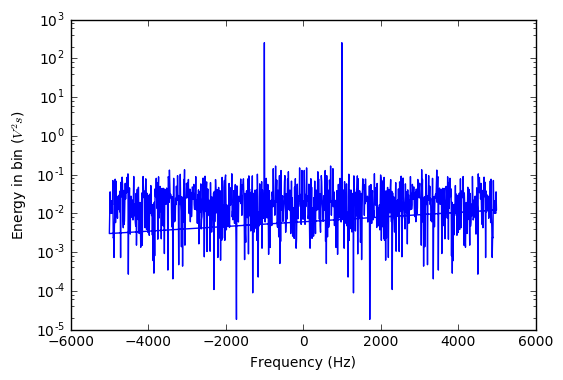

In [41]:
Exx = np.abs(X) ** 2

plt.semilogy(f, Exx)
plt.title('Energy Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy in bin ($V^2s$)')

Let's convert the FFT values to power. In the time domain, we divided the sum energy by N. This is what we do in the frequency domain, too to get average power in each freq bin. If you followed carefully, we normalized the the FFT squared magnitudes by N to get energy and again by N to get power. __This is why people prefer to normalize the FFT values by N (so the squared magnitudes are in the power units)__.

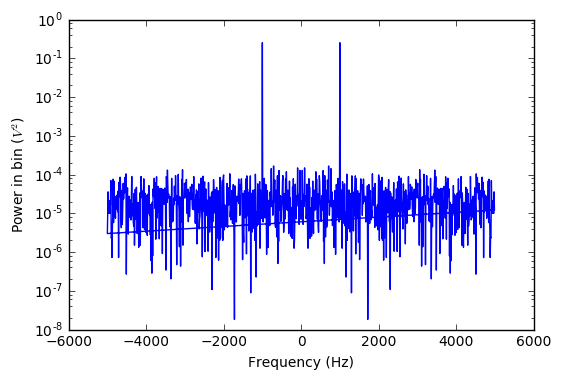

In [42]:
Pxx = Exx / N
plt.semilogy(f, Pxx)
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power in bin ($V^2$)')

Due to the real time-domain samples we have a symmetric spectrum (complex conjugate). Let's take and scale the positive half of it.

(1e-06, 1)

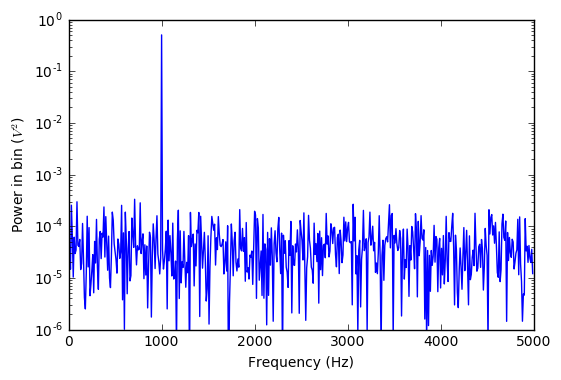

In [43]:
Pxx = Pxx[:N // 2]
Pxx[1:-2] *= 2    # conserve energy
f = f[:N // 2]

plt.semilogy(f, Pxx)
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power in bin ($V^2$)')
plt.ylim(1e-6, 1)
plt.grid()

Let's compare the result with the built-in periodogram function.

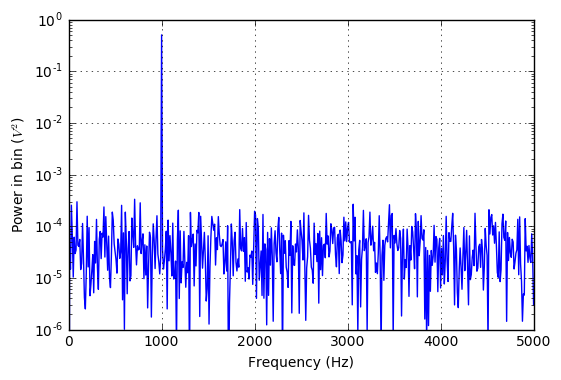

In [55]:
f2, Pxx2  = signal.periodogram(samples, FS, nfft=N, scaling='spectrum')
plt.semilogy(f2, Pxx2)
plt.title('Power Spectrum using scipy.signal.periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power in bin ($V^2$)')
plt.ylim(1e-6, 1)
plt.grid()
plt.show()

Calculate SNR using the frequency domain (first peak is the signal assumption).

In [50]:
f_sig_idx = np.argmax(Pxx)
SNR_f = 10 * np.log10(Pxx[f_sig_idx] / np.sum(np.delete(Pxx, f_sig_idx)))

print('SNR= %.2f dB (time domain SNR= %.2f dB)' % (SNR_f, SNR_t))

SNR= 12.81 dB (time domain SNR= 12.02 dB)


## Power Spectrum Density

Instead of ploting the (average) power in each frequency bin we can compute/plot the power density. This is a scaling of the power spectrum results by the width of the bin (in Hz). We also compare this to the built-in periodogram with density scaling.

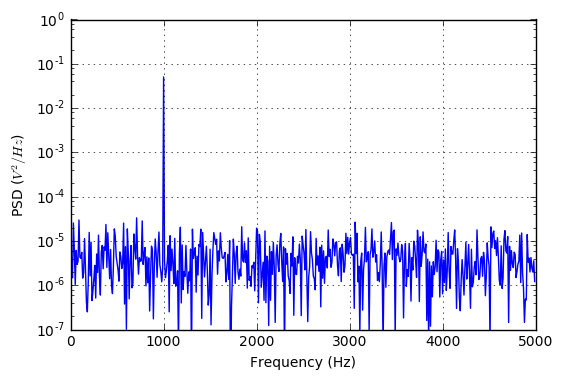

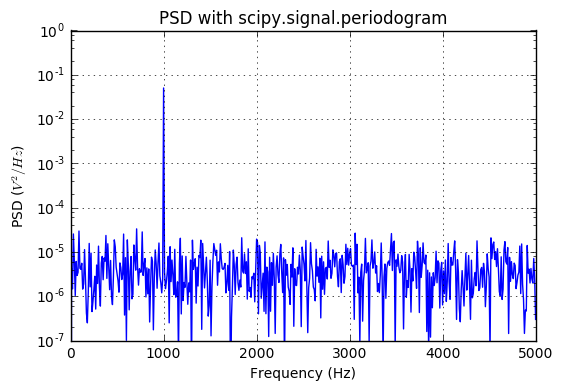

In [58]:
plt.semilogy(f, Pxx / (FS / N))
plt.title('PSD computed from DFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
plt.show()

f2, Pxx2  = signal.periodogram(samples, FS, nfft=N, scaling='density')
plt.semilogy(f2, Pxx2)
plt.title('PSD using scipy.signal.periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()


__Observation__: the PSD figure is better for showing the noise level (it's height does not change with N), but is hard to interpret for the signal (it's height changes). The 'spectrum' scaling is better for the signal (does not change with N) but misleading for the noise level.

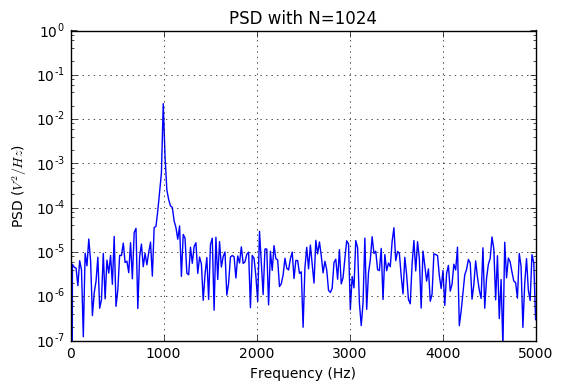

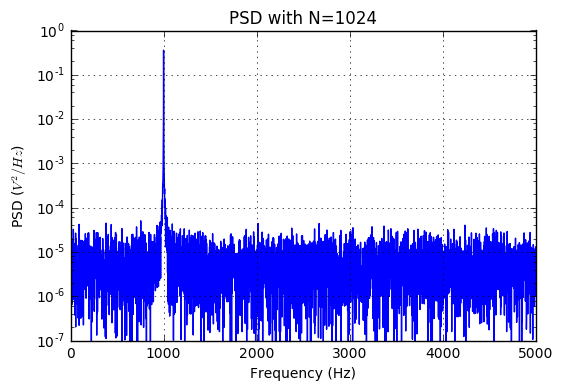

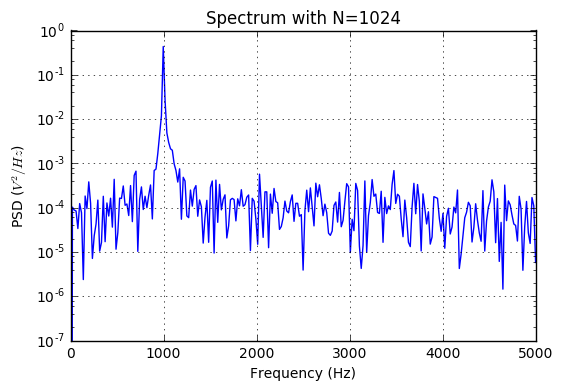

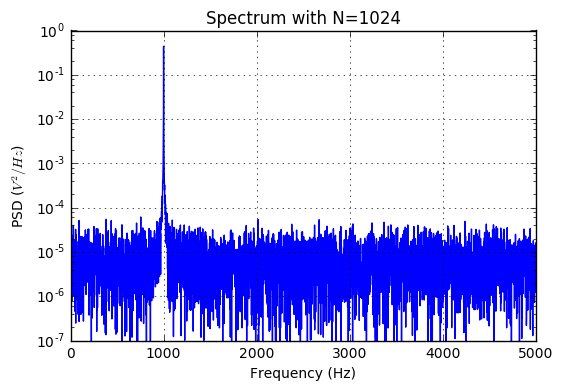

In [60]:
f3, Pxx3  = signal.periodogram(samples, FS, nfft=512, scaling='density')
plt.semilogy(f3, Pxx3)
plt.title('PSD with N=1024')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
plt.show()

f3, Pxx3  = signal.periodogram(samples, FS, nfft=8192, scaling='density')
plt.semilogy(f3, Pxx3)
plt.title('PSD with N=1024')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
plt.show()

f3, Pxx3  = signal.periodogram(samples, FS, nfft=512, scaling='spectrum')
plt.semilogy(f3, Pxx3)
plt.title('Power Spectrum with N=1024')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
plt.show()

f3, Pxx3  = signal.periodogram(samples, FS, nfft=8192, scaling='spectrum')
plt.semilogy(f3, Pxx3)
plt.title('Power Spectrum with N=1024')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($V^2/Hz$)')
plt.ylim(1e-7, 1)
plt.grid()
plt.show()

## TODO: Windowing